In [35]:
import os
import math
import numpy as np
import json
import pickle
import random
from collections import defaultdict

import osmnx as ox

from tqdm import tqdm
import matplotlib.pyplot as plt

from data import get_data
from random_walks import get_end_nodes, angle_diff
from utils import float2color

Graph has 966 nodes and 2400 edges.


Assign each state to a "canonical index" starting from zero.

In [3]:
def matrix_method(slug):
    G, adj, boba_gdf = get_data(slug)
    print(f"Graph has {len(adj)} nodes and {len(G.edges())} edges.")
    end_nodes = get_end_nodes(G, boba_gdf)

    incoming = defaultdict(list)
    for node in adj:
        for edge in adj[node]:
            incoming[edge[0]].append(node)
    for node in incoming:
        incoming[node].sort()
    
    states = []
    for node in sorted(adj.keys()):
        states.extend([(node, prev) for prev in incoming[node]])
    state2idx = {state: idx for idx, state in enumerate(states)}

    print(f"{len(states):,} states total.")

Construct this huge matrix!

Basically, we want to solve for a vector $\vec v$ that contains the expected number of steps till reaching a boba shop.

In [112]:
angle_cutoff = np.pi/6
forward_favor = 8

N = len(states)
A = np.zeros((N, N + 1))

for i, state in enumerate(tqdm(states)):
    assert(i == state2idx[state])
    node, prev = state

    if node in end_nodes:
        continue

    # Weigh next routes
    cur_angle = next(angle2 for nbr, _, _, angle2 in adj[node] if nbr == prev)

    weights = []
    travel_times = []
    for nbr, length, angle1, angle2 in adj[node]:
        if nbr == prev:
            weight = 1e-9
        elif abs(angle_diff(cur_angle, angle1)) < angle_cutoff:
            weight = forward_favor
        else:
            weight = 1
        weights.append(weight)
        travel_times.append(length / 4 / 1000 * 60)
    
    # Normalize weights, calculate expected travel time
    weights = np.array(weights) / np.sum(weights)
    E_travel_time = weights @ np.array(travel_times)

    # Record probability of going to (nbr, node) from (node, prev)
    for j, edge in enumerate(adj[node]):
        nbr = edge[0]
        A[state2idx[(node, prev)],state2idx[(nbr, node)]] = weights[j]
    
    # Record expected travel time
    A[state2idx[(node, prev)],-1] = E_travel_time
    
    assert np.isclose(weights.sum(), 1)

100%|██████████| 2400/2400 [00:00<00:00, 7646.75it/s]


In [113]:
A[0][np.where(A[0] > 0)]

array([1.     , 0.58092])

In [115]:
rowsums = np.sum(A[:,:-1], axis=1)
print(rowsums[0])

1.0


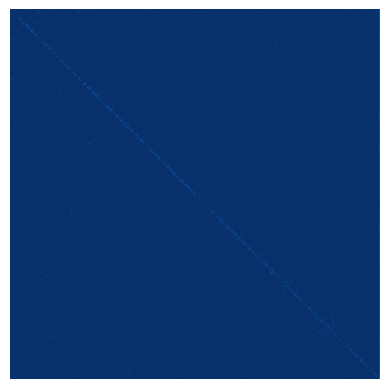

In [116]:
plt.imshow(np.log(A + 1e-9), cmap="Blues_r")
plt.axis("off");

In [117]:
A2 = np.vstack([A, np.zeros(N + 1)])
b = np.zeros((N + 1, 1))
b[-1] = -1

v = np.linalg.inv(A2 - np.eye(N + 1)) @ b

In [125]:
np.sum(np.isclose(A2 @ v, v))
v.size

2401

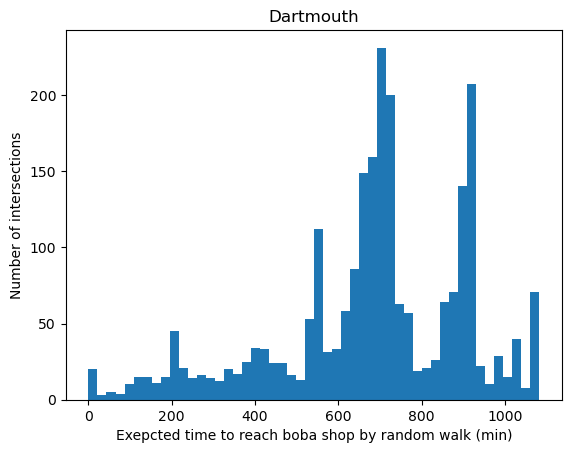

In [129]:
plt.xlabel("Exepcted time to reach boba shop by random walk (min)")
plt.ylabel("Number of intersections")
plt.title("Dartmouth")
plt.hist(v, bins=50);

In [130]:
os.makedirs("./output/matrix_method", exist_ok=True)
with open(f"./output/matrix_method/{slug}.pkl", "wb") as fout:
    pickle.dump({
        "expected_time": v[:-1],
        "states": states
    }, fout)